In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("ANALISIS PREDIKSI PENERIMAAN BEASISWA MENGGUNAKAN RANDOM FOREST")
print("dengan SMOTE untuk Menangani Class Imbalance")
print("="*80)

ANALISIS PREDIKSI PENERIMAAN BEASISWA MENGGUNAKAN RANDOM FOREST
dengan SMOTE untuk Menangani Class Imbalance


In [3]:
# ==========================================
# 1. LOAD DATA
# ==========================================
df = pd.read_csv('beasiswa.csv', sep=';')
print(f"\n[INFO] Dataset berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")


[INFO] Dataset berhasil dimuat: 300 baris, 9 kolom


In [4]:
print(df.shape)
df.head()

(300, 9)


,IPK,Semester,Penghasilan_Ortu,Tanggungan_Keluarga,Prestasi,Aktif_Organisasi,Status_Rumah,Jenis_Kelamin,Diterima_Beasiswa
0,3.37,2,2000000,3,Internasional,Tidak,Milik Sendiri,P,0
1,3.15,5,4000000,6,Tidak Ada,Ya,Kos/Asrama,P,1
2,3.43,3,1500000,6,Provinsi,Ya,Kontrak,P,1
3,3.73,6,1000000,5,Tidak Ada,Tidak,Milik Sendiri,L,1
4,3.12,2,500000,1,Tidak Ada,Tidak,Milik Sendiri,P,1


In [5]:
# ================================
# HAPUS FITUR TERTENTU
# ================================

kolom_dihapus = [
    "Tanggungan_Keluarga",
    "Status_Rumah",
    "Jenis_Kelamin"
]

df = df.drop(columns=kolom_dihapus, errors="ignore")

In [6]:
print(df.shape)
df.head()

(300, 6)


,IPK,Semester,Penghasilan_Ortu,Prestasi,Aktif_Organisasi,Diterima_Beasiswa
0,3.37,2,2000000,Internasional,Tidak,0
1,3.15,5,4000000,Tidak Ada,Ya,1
2,3.43,3,1500000,Provinsi,Ya,1
3,3.73,6,1000000,Tidak Ada,Tidak,1
4,3.12,2,500000,Tidak Ada,Tidak,1



EXPLORATORY DATA ANALYSIS (EDA) - SEBELUM PREPROCESSING

--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IPK                300 non-null    float64
 1   Semester           300 non-null    int64  
 2   Penghasilan_Ortu   300 non-null    int64  
 3   Prestasi           300 non-null    int64  
 4   Aktif_Organisasi   300 non-null    int64  
 5   Diterima_Beasiswa  300 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 14.2 KB
None

--- Statistik Deskriptif ---
              IPK    Semester  Penghasilan_Ortu    Prestasi  Aktif_Organisasi  \
count  300.000000  300.000000      3.000000e+02  300.000000        300.000000   
mean     3.195400    4.906667      2.065000e+06    0.946667          0.456667   
std      0.336704    1.999487      1.283393e+06    1.123103          0.498951   
min      2.070000 

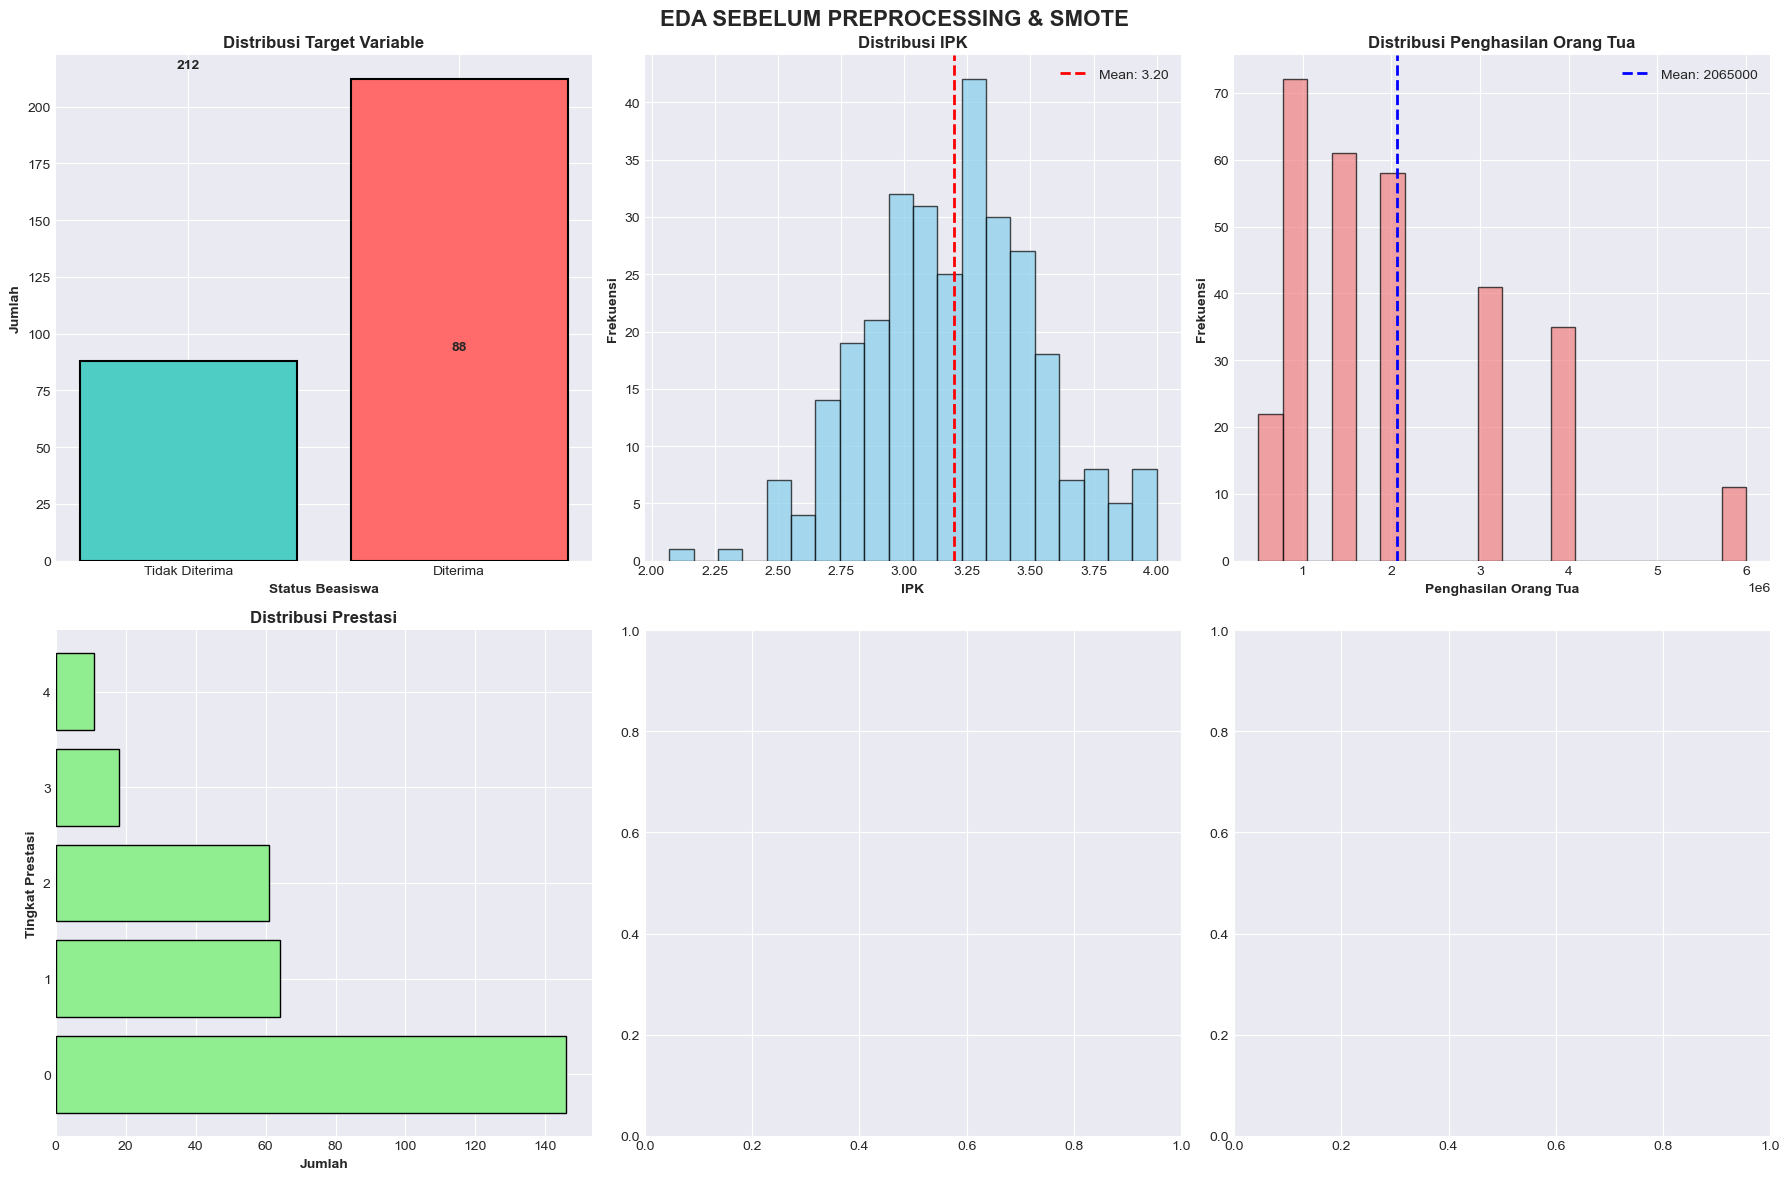

In [14]:
# ==========================================
# 2. EDA AWAL (SEBELUM PREPROCESSING)
# ==========================================
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS (EDA) - SEBELUM PREPROCESSING")
print("="*80)

# 2.1 Informasi Dataset
print("\n--- Informasi Dataset ---")
print(df.info())

# 2.2 Statistik Deskriptif
print("\n--- Statistik Deskriptif ---")
print(df.describe())

# 2.3 Distribusi Target Variable
print("\n--- Distribusi Target Variable ---")
print(df['Diterima_Beasiswa'].value_counts())
print("\nPersentase:")
print(df['Diterima_Beasiswa'].value_counts(normalize=True) * 100)

# 2.4 Cek Missing Values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# 2.5 Visualisasi Distribusi Target (SEBELUM SMOTE)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('EDA SEBELUM PREPROCESSING & SMOTE', fontsize=16, fontweight='bold')

# Plot 1: Distribusi Target
ax1 = axes[0, 0]
target_counts = df['Diterima_Beasiswa'].value_counts()
colors = ['#ff6b6b', '#4ecdc4']
ax1.bar(target_counts.index, target_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Status Beasiswa', fontweight='bold')
ax1.set_ylabel('Jumlah', fontweight='bold')
ax1.set_title('Distribusi Target Variable', fontweight='bold')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Tidak Diterima', 'Diterima'])
for i, v in enumerate(target_counts.values):
    ax1.text(i, v + 5, str(v), ha='center', fontweight='bold')

# Plot 2: Distribusi IPK
ax2 = axes[0, 1]
ax2.hist(df['IPK'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('IPK', fontweight='bold')
ax2.set_ylabel('Frekuensi', fontweight='bold')
ax2.set_title('Distribusi IPK', fontweight='bold')
ax2.axvline(df['IPK'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["IPK"].mean():.2f}')
ax2.legend()

# Plot 3: Distribusi Penghasilan Orang Tua
ax3 = axes[0, 2]
ax3.hist(df['Penghasilan_Ortu'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Penghasilan Orang Tua', fontweight='bold')
ax3.set_ylabel('Frekuensi', fontweight='bold')
ax3.set_title('Distribusi Penghasilan Orang Tua', fontweight='bold')
ax3.axvline(df['Penghasilan_Ortu'].mean(), color='blue', linestyle='--', linewidth=2, 
            label=f'Mean: {df["Penghasilan_Ortu"].mean():.0f}')
ax3.legend()

# Plot 4: Distribusi Prestasi
ax4 = axes[1, 0]
prestasi_counts = df['Prestasi'].value_counts()
ax4.barh(prestasi_counts.index, prestasi_counts.values, color='lightgreen', edgecolor='black')
ax4.set_xlabel('Jumlah', fontweight='bold')
ax4.set_ylabel('Tingkat Prestasi', fontweight='bold')
ax4.set_title('Distribusi Prestasi', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_sebelum_preprocessing.png', dpi=300, bbox_inches='tight')
print("\n[SAVED] Visualisasi EDA sebelum preprocessing: 'eda_sebelum_preprocessing.png'")

In [8]:
# ==========================================
# 3. PREPROCESSING & DATA TRANSFORMATION
# ==========================================
print("\n" + "="*80)
print("DATA PREPROCESSING & TRANSFORMATION")
print("="*80)

# 3.1 Ordinal Encoding untuk Prestasi
prestasi_map = {'Tidak Ada': 0, 'Kabupaten': 1, 'Provinsi': 2, 'Nasional': 3, 'Internasional': 4}
df['Prestasi'] = df['Prestasi'].map(prestasi_map)
print("\n[TRANSFORM] Prestasi: Ordinal Encoding (0-4)")

# 3.2 Binary Encoding
df['Aktif_Organisasi'] = df['Aktif_Organisasi'].map({'Tidak': 0, 'Ya': 1})
print("[TRANSFORM] Aktif_Organisasi & Jenis_Kelamin: Binary Encoding (0/1)")

print("\n--- Kolom setelah preprocessing ---")
print(df.columns.tolist())


DATA PREPROCESSING & TRANSFORMATION

[TRANSFORM] Prestasi: Ordinal Encoding (0-4)
[TRANSFORM] Aktif_Organisasi & Jenis_Kelamin: Binary Encoding (0/1)

--- Kolom setelah preprocessing ---
['IPK', 'Semester', 'Penghasilan_Ortu', 'Prestasi', 'Aktif_Organisasi', 'Diterima_Beasiswa']



ANALISIS KORELASI

[SAVED] Heatmap Korelasi: 'correlation_heatmap.png'

--- Korelasi dengan Target Variable ---
Diterima_Beasiswa    1.000000
IPK                  0.254727
Prestasi             0.145657
Aktif_Organisasi     0.076234
Semester            -0.044795
Penghasilan_Ortu    -0.210169
Name: Diterima_Beasiswa, dtype: float64


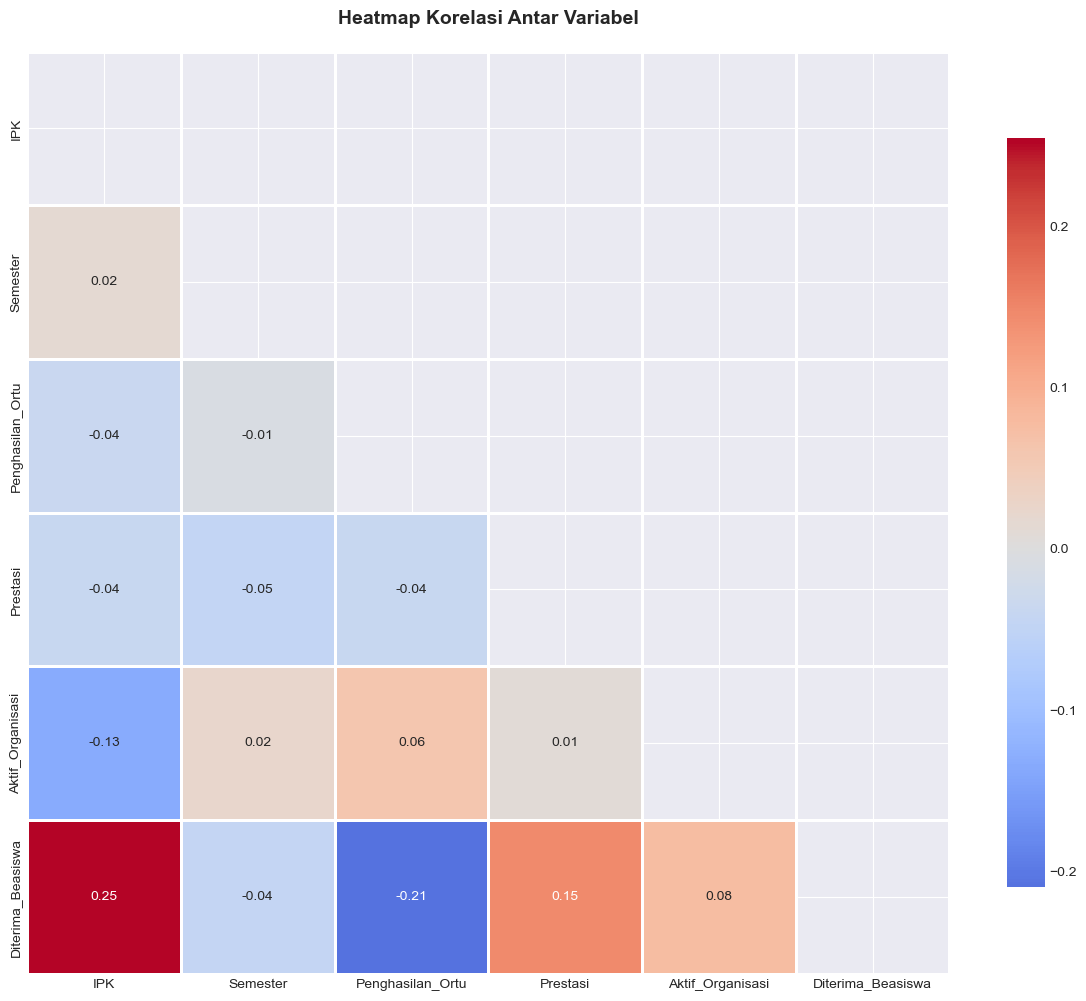

In [9]:
# ==========================================
# 4. ANALISIS KORELASI
# ==========================================
print("\n" + "="*80)
print("ANALISIS KORELASI")
print("="*80)

# Heatmap Korelasi
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Heatmap Korelasi Antar Variabel', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("\n[SAVED] Heatmap Korelasi: 'correlation_heatmap.png'")

# Top Korelasi dengan Target
target_corr = correlation_matrix['Diterima_Beasiswa'].sort_values(ascending=False)
print("\n--- Korelasi dengan Target Variable ---")
print(target_corr)

In [10]:
# ==========================================
# 5. DATA SPLITTING
# ==========================================
X = df.drop('Diterima_Beasiswa', axis=1)
y = df['Diterima_Beasiswa']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n[INFO] Data Split:")
print(f"  - Training: {len(X_train)} samples")
print(f"  - Testing: {len(X_test)} samples")


[INFO] Data Split:
  - Training: 210 samples
  - Testing: 90 samples


In [11]:
# ==========================================
# 9. MODEL TRAINING dengan HYPERPARAMETER TUNING
# ==========================================
print("\n" + "="*80)
print("TRAINING MODEL NAIVE BAYES")
print("="*80)

# Inisialisasi Gaussian Naive Bayes
nb_model = GaussianNB()

# Latih model dengan data yang sudah di-SMOTE
nb_model.fit(X_train, y_train)

# Prediksi data test
y_pred = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)[:, 1]

print("[INFO] Model Naive Bayes berhasil dilatih.")



TRAINING MODEL NAIVE BAYES
[INFO] Model Naive Bayes berhasil dilatih.



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.50      0.04      0.07        26
           1       0.72      0.98      0.83        64

    accuracy                           0.71        90
   macro avg       0.61      0.51      0.45        90
weighted avg       0.65      0.71      0.61        90



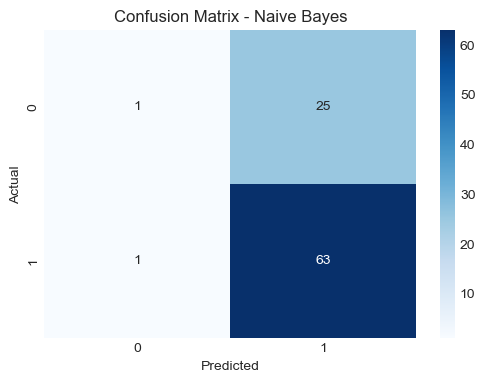

In [12]:
# ==========================================
# 10. EVALUASI MODEL
# ==========================================
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier
import pickle

print("\n" + "="*80)
print("SAVE MODEL")
print("="*80)

filename = 'nb_beasiswa_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(nb_model, file)

print(f"\n[SUCCESS] Model disimpan sebagai: {filename}")



SAVE MODEL

[SUCCESS] Model disimpan sebagai: nb_beasiswa_model.pkl
